##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
orig_df = pd.read_csv('./Dataset/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [4]:
df = pd.read_csv('./Dataset/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [8]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


X & Y : Denotes the location coordinates i.e., latitude and longitude                                                       
Area_Command : Place where the crime happend                                                                                    
NIBRSOffense Code : Denotes the type of crime                                                                                   
DayOfWeek : On which day the incident happend                                                                                   
Time : At what time the incident happened                                                                                       
VictimCount : No.of people involved    
input variables : X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time                                                         
Target variables : VictimCount

We dont need to scale, shift and normalize the data.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [9]:
from torch.utils.data import DataLoader, random_split, TensorDataset

X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
Y = df['VictimCount'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)


dataset = TensorDataset(X_tensor, Y_tensor)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch_X, batch_Y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch Y shape:", batch_Y.shape)
    break


Batch X shape: torch.Size([32, 6])
Batch Y shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

The loss function that is used is MSE which is common for regression tasks                                                  
The neural network architecture used is a feedforward neural network with three fully connected dense layers and            
used 64 neurons in layer_1 and 32 in layer_2                                                                                
The optimizer that used was Adam with a learning rate of 0.001.


In [13]:
import torch.nn as nn
import torch.optim as optim


loss_function = nn.MSELoss()
input_size = 6

class CustomCrimeRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(CustomCrimeRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomCrimeRegressionModel(input_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()

    train_loss = train_loss / len(train_loader)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            predictions = model(batch_X)
            loss = loss_function(predictions, batch_Y)
            test_loss =test_loss + loss.item()

    test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.2f}, Test MSE Error: {test_loss:.2f}")


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/30] - Train Loss: 1.16, Test MSE Error: 1.60
Epoch [2/30] - Train Loss: 1.02, Test MSE Error: 1.21
Epoch [3/30] - Train Loss: 0.99, Test MSE Error: 1.22
Epoch [4/30] - Train Loss: 0.96, Test MSE Error: 1.54
Epoch [5/30] - Train Loss: 0.90, Test MSE Error: 1.34
Epoch [6/30] - Train Loss: 1.05, Test MSE Error: 1.93
Epoch [7/30] - Train Loss: 1.07, Test MSE Error: 1.25
Epoch [8/30] - Train Loss: 0.92, Test MSE Error: 1.34
Epoch [9/30] - Train Loss: 0.88, Test MSE Error: 1.21
Epoch [10/30] - Train Loss: 0.93, Test MSE Error: 1.28
Epoch [11/30] - Train Loss: 0.92, Test MSE Error: 1.23
Epoch [12/30] - Train Loss: 0.92, Test MSE Error: 1.24
Epoch [13/30] - Train Loss: 0.89, Test MSE Error: 1.24
Epoch [14/30] - Train Loss: 0.94, Test MSE Error: 1.22
Epoch [15/30] - Train Loss: 0.89, Test MSE Error: 1.32
Epoch [16/30] - Train Loss: 0.93, Test MSE Error: 1.19
Epoch [17/30] - Train Loss: 0.89, Test MSE Error: 1.24
Epoch [18/30] - Train Loss: 0.89, Test MSE Error: 1.23
Epoch [19/30] - Tra

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In the architecture we use size of input layer as 6 and the no.of neurons in layer_1 is 64 and for the layer_2 is 16.       
The loss function that was used is CrossEntropy function.This loss function is commonly used for multi-class classification
problems. It combines the Softmax activation function and the negative log-likelihood loss to compute the loss between 
predicted class probabilities and true class labels.

In [12]:
loss_function = nn.CrossEntropyLoss()

input_size = 6
num_classes = 16

class CustomCrimeClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomCrimeClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = CustomCrimeClassificationModel(input_size, num_classes)

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)

        batch_Y = batch_Y.to(torch.long)

        loss = loss_function(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        train_loss += train_loss + loss.item()

        _, predicted = torch.max(predictions, 1)
        correct_train = correct_train + (predicted == batch_Y).sum().item()

    train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    correct_test = 0

    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            predictions = model(batch_X)

            batch_Y = batch_Y.to(torch.long)

            loss = loss_function(predictions, batch_Y)
            test_loss = test_loss + loss.item()

            _, predicted = torch.max(predictions, 1)
            correct_test = correct_test + (predicted == batch_Y).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}, Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")


Epoch [1/30] - Train Loss: 91.50, Train Accuracy: 0.41, Test Loss: 1.62, Test Accuracy: 0.45
Epoch [2/30] - Train Loss: 25.71, Train Accuracy: 0.48, Test Loss: 1.89, Test Accuracy: 0.45
Epoch [3/30] - Train Loss: 27.87, Train Accuracy: 0.42, Test Loss: 1.56, Test Accuracy: 0.45
Epoch [4/30] - Train Loss: 25.03, Train Accuracy: 0.50, Test Loss: 1.39, Test Accuracy: 0.40
Epoch [5/30] - Train Loss: 20.26, Train Accuracy: 0.48, Test Loss: 1.47, Test Accuracy: 0.45
Epoch [6/30] - Train Loss: 19.29, Train Accuracy: 0.47, Test Loss: 1.31, Test Accuracy: 0.45
Epoch [7/30] - Train Loss: 18.31, Train Accuracy: 0.51, Test Loss: 1.32, Test Accuracy: 0.45
Epoch [8/30] - Train Loss: 21.13, Train Accuracy: 0.47, Test Loss: 1.28, Test Accuracy: 0.45
Epoch [9/30] - Train Loss: 19.19, Train Accuracy: 0.53, Test Loss: 1.34, Test Accuracy: 0.45
Epoch [10/30] - Train Loss: 18.86, Train Accuracy: 0.52, Test Loss: 1.29, Test Accuracy: 0.55
Epoch [11/30] - Train Loss: 17.69, Train Accuracy: 0.53, Test Loss: 1

In [15]:

from sklearn.model_selection import train_test_split

learning_rates = [0.001, 0.01, 0.1]
hidden_layer_dimensions = [(64, 32), (128, 32), (256, 64)]

best_accuracy = 0.0
best_model = None

for lr in learning_rates:
    for hidden_dim in hidden_layer_dimensions:
        class NeuralNetworkC(nn.Module):
            def __init__(self, input_size, num_classes):
                super(NeuralNetworkC, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_dim[0])
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
                self.fc3 = nn.Linear(hidden_dim[1], num_classes)

            def forward(self, x):
                x = self.fc1(x)
                x = self.relu(x)
                x = self.fc2(x)
                x = self.relu(x)
                x = self.fc3(x)
                return x

        model = NeuralNetworkC(input_size, num_classes)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        num_epochs = 50

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            correct_train = 0

            for batch_X, batch_Y in train_loader:
                optimizer.zero_grad()
                predictions = model(batch_X)

                batch_Y = batch_Y.to(torch.long)

                loss = loss_function(predictions, batch_Y)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(predictions, 1)
                correct_train  = correct_train +  (predicted == batch_Y).sum().item()

            train_loss = train_loss/ len(train_loader)
            train_accuracy = correct_train / len(train_loader.dataset)

            model.eval()
            test_loss = 0.0
            correct_test = 0

            with torch.no_grad():
                for batch_X, batch_Y in test_loader:
                    predictions = model(batch_X)
                    batch_Y = batch_Y.to(torch.long)

                    loss = loss_function(predictions, batch_Y)
                    test_loss = test_loss + loss.item()

                    _, predicted = torch.max(predictions, 1)
                    correct_test = correct_test + (predicted == batch_Y).sum().item()

            test_loss = test_loss / len(test_loader)
            test_accuracy = correct_test / len(test_loader.dataset)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print(f"Best Test Accuracy: {best_accuracy:.4f}")


Best Test Accuracy: 0.4909


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

The classification worked better because categorial values classifcation works better and for the continuous values regression works better

Misclassified Example True Label: 1.0


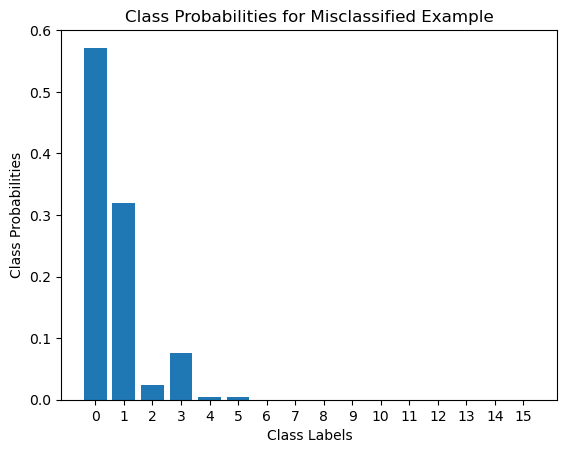

In [16]:
model.eval()

misclassified_examples = []
true_labels = []

for batch_X, batch_Y in test_loader:
    predictions = model(batch_X)
    predicted_labels = torch.argmax(predictions, dim=1)

    misclassified_indices = (predicted_labels != batch_Y).nonzero()

    if misclassified_indices.numel() > 0:
        misclassified_examples.extend(batch_X[misclassified_indices])
        true_labels.extend(batch_Y[misclassified_indices])
        break

if len(misclassified_examples) > 0:
    misclassified_example = misclassified_examples[0]
    true_label = true_labels[0]

    print(f'Misclassified Example True Label: {true_label.item()}')

    probabilities = torch.softmax(predictions[0], dim=0).tolist()
    class_labels = list(range(num_classes))

    plt.bar(class_labels, probabilities, tick_label=class_labels)
    plt.xlabel('Class Labels')
    plt.ylabel('Class Probabilities')
    plt.title('Class Probabilities for Misclassified Example')
    plt.show()
else:
    print("No misclassified examples found in the test data.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


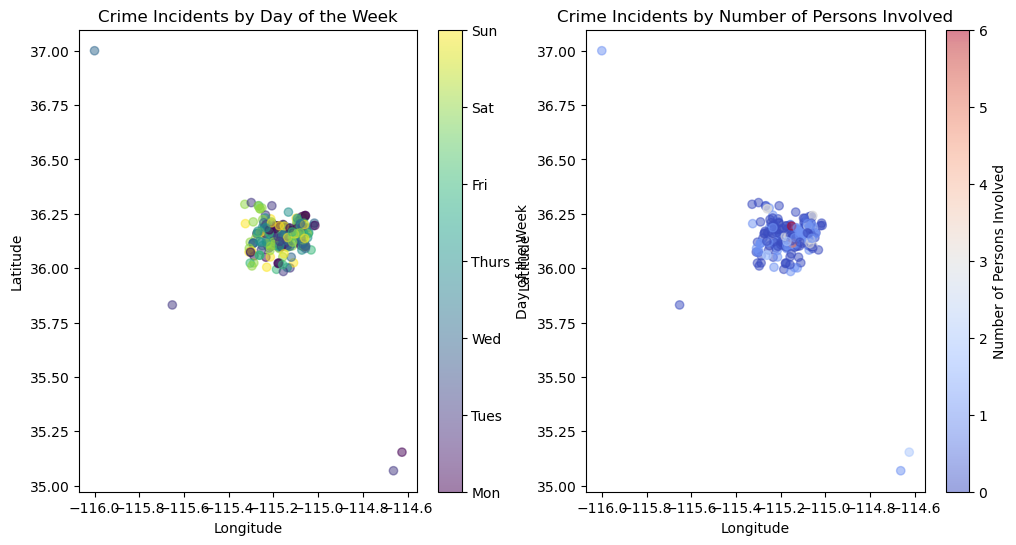

Most frequent day for crimes: Fri


In [19]:

crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()

day_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

scatter1 = axes[0].scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.5)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Crime Incidents by Day of the Week')
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Day of the Week')
cbar1.set_ticks(range(7))
cbar1.set_ticklabels(day_names)

scatter2 = axes[1].scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='coolwarm', alpha=0.5)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Crime Incidents by Number of Persons Involved')
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Number of Persons Involved')

plt.show()

most_frequent_day = day_names[crime_counts_by_day.idxmax()]
print(f"Most frequent day for crimes: {day_names[crime_counts_by_day.idxmax()]}")

